In [16]:
library("ggplot2")
library("dplyr")
library("scales")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Introducción

En el presente capítulo se realizará el análisis para la serie de tiempo cantidad de viajes realizados en la Ciudad de México utilizando las bicicletas del programa de gobierno *EcoBici*, en base a *splines cúbicos*.



Los datos se encuentran presentes en cada una de las bases de datos, las cuales pueden obtenerse descargándolas desde la página oficial del programa [Ecobici](https://www.ecobici.cdmx.gob.mx/es/informacion-del-servicio/open-data). Los datos son mensuales y se cuenta con información desde febrero de $2010$ hasta mayo $2020$, por lo que se tiene un total de $124$ observaciones, las cuales representan la cantidad de viajes realizados en el respectivo mes y año.

# Objetivo

Interpolar la cantidad de viajes realizados desde que se tiene información comparando entre los resultados al realizar la interpolación tomando observaciones a nivel:


* Semestral
* Anual
* Bianual


Y decidir qué corte obtiene un mejor desempeño en base al error cuadrático medio.

# Metodología

### Lectura y preparación de datos

In [1]:
data <- read.csv("EcoBici.csv", stringsAsFactors = FALSE) ### No se desea que el anio sea un factor, lo queremos como string

In [2]:
head(data)

,Anio,Viajes
,<chr>,<int>
1,2010-02,1057
2,2010-03,21024
3,2010-04,44984
4,2010-05,59814
5,2010-06,64704
6,2010-07,58767


In [3]:
tail(data)

,Anio,Viajes
,<chr>,<int>
119,2019-12,584185
120,2010-01,676908
121,2010-02,686327
122,2010-03,529077
123,2010-04,159780
124,2010-05,153147


Los últimos $5$ años deberían indicar $2020$ en la sección del año, a pesar de que indique $2010$.

In [4]:
data$Anio[120:124] <- gsub("2010", "2020", data$Anio[120:124])

Se prefiere trabajar con letras minúsculas, por lo que se cambiará la primera letra del nombre de cada columna a minúscula, además la primer columna `anio` no hace referencia al año únicamente, sino también al mes correspondiente, por lo que hará el cambio del nombre a `fecha`.

In [5]:
colnames(data) <- c("fecha", "viajes")

### Estructura de datos

In [6]:
summary(data)

    fecha               viajes      
 Length:124         Min.   :  1057  
 Class :character   1st Qu.:218704  
 Mode  :character   Median :665850  
                    Mean   :540405  
                    3rd Qu.:745155  
                    Max.   :878358  

In [7]:
str(data)

'data.frame':	124 obs. of  2 variables:
 $ fecha : chr  "2010-02" "2010-03" "2010-04" "2010-05" ...
 $ viajes: int  1057 21024 44984 59814 64704 58767 82329 100164 132294 134082 ...


Nótese que la variable `fecha` aparece como  `chr`, cuando en realidad debería ser un objeto `date` de `R`, a continuación se realizará el cambio correspondiente, para ello se supondrá que todos los meses tienen $28$ días, pues la función `as.Date`, presenta dificultades al tratar de identificar un mes que en tiene $28$ días (febrero) al momento de agregarle $30$ días o más.

In [8]:
data$fecha <- as.Date(paste0(data$fecha,"-28"))

Para efectos de este análisis y para facilitar la selección de los distintos cortes (semestral, anual y bianual) se agregará la observación $2010-01-28$ que hace referencia al $28$ de enero de $2010$.

In [9]:
new_obs <- data.frame(fecha = as.Date("2010-01-28"), viajes = 0)
new_data <- rbind(new_obs, data)
head(new_data, 12)

,fecha,viajes
,<date>,<dbl>
1,2010-01-28,0
2,2010-02-28,1057
3,2010-03-28,21024
4,2010-04-28,44984
5,2010-05-28,59814
6,2010-06-28,64704
7,2010-07-28,58767
8,2010-08-28,82329
9,2010-09-28,100164


### Splines cúbicos

In [10]:
n <- nrow(new_data)

In [11]:
sem <- seq(6, n, 6)
anual <- seq(12, n, 12)
bianual <- seq(24, n, 24)

In [12]:
data_sem <- new_data[sem,]
data_anual <- new_data[anual,]
data_bian <- new_data[bianual,]

In [29]:
spl_sem <- spline(data_sem$fecha, data_sem$viajes)
spl_an <- spline(data_anual$fecha, data_anual$viajes)
spl_bian <- spline(data_bian$fecha, data_bian$viajes)

ERROR while rich displaying an object: Error: Invalid input: date_trans works with objects of class Date only

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.defau

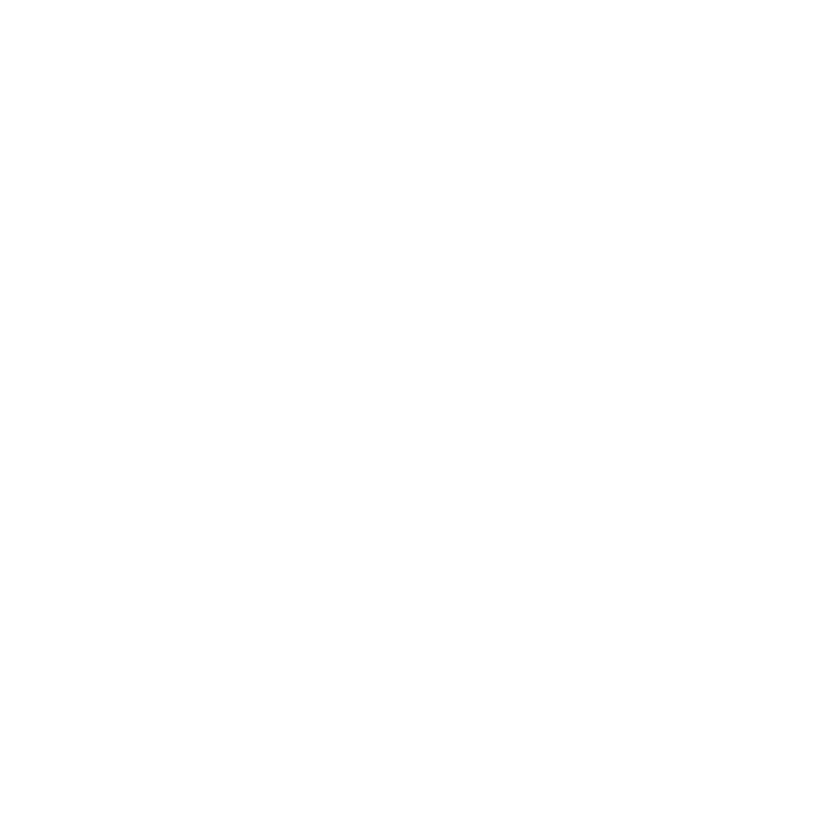

In [124]:
ggplot(data = data.frame(fecha = spl_sem$x, viajes = spl_sem$y), aes(fecha, viajes)) + 
    theme_light() +
    geom_line(color = "red") +
    geom_line(data = data.frame(fecha = spl_an$x, viajes = spl_an$y), color = "blue") +
    geom_line(data = data.frame(fecha = spl_bian$x, viajes = spl_bian$y), color = "#6DCE0A") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    scale_x_date(breaks='1 years', date_labels = "%b, %Y", limits = c(as.Date(min(new_data$fecha)), 
                                                                      as.Date(max(new_data$fecha)))) + 
    xlab("Fecha") + 
    ylab("Viajes") +
    ggtitle("Cantidad de viajes realizados con EcoBici")

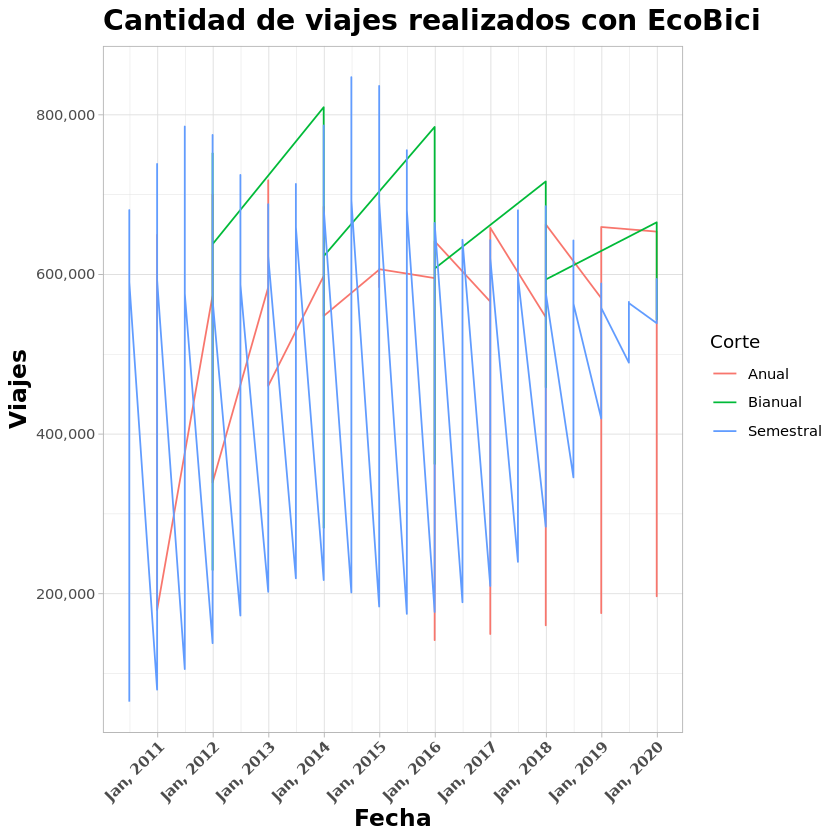

In [68]:
ggplot(data_result, aes(x = fecha, y = viajes, color = Corte)) + 
    theme_light() +
    geom_line() + 
    scale_x_date(breaks='1 years', date_labels = "%b, %Y", limits = c(mi)) + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1, face = "bold"), 
          plot.title = element_text(size = 17, face = "bold"), 
          axis.title = element_text(size=14, face="bold")) + 
    scale_y_continuous(labels = comma) +
    xlab("Fecha") + 
    ylab("Viajes") +
    ggtitle("Cantidad de viajes realizados con EcoBici")

In [108]:
str(data_sem)

'data.frame':	20 obs. of  2 variables:
 $ fecha : Date, format: "2010-06-28" "2010-12-28" ...
 $ viajes: num  64704 141860 220447 179684 197067 ...


In [35]:
data_result <- data.frame(fecha = c(spl_sem$x, spl_an$x, spl_bian$x),
                          viajes = c(spl_sem$y, spl_an$y, spl_bian$y),
                          Corte = c(rep("Semestral", nrow(data_sem)), 
                                    rep("Anual", nrow(data_anual)), 
                                    rep("Bianual", nrow(data_bian))))

In [122]:
str(c(min(new_data$fecha), max(new_data$fecha)))

 Date[1:2], format: "2010-01-28" "2020-05-28"
